In [3]:

import pandas as pd

# Load the uploaded datasets
sentiment_df = pd.read_csv("C:/Users/91770/OneDrive/Desktop/primetrade.ai/fear_greed_index.csv")
trader_df = pd.read_csv("C:/Users/91770/OneDrive/Desktop/primetrade.ai/historical_data.csv")

# Display basic info
sentiment_info = sentiment_df.info()
trader_info = trader_df.info()

# Preview first few rows of each
sentiment_head = sentiment_df.head()
trader_head = trader_df.head()

sentiment_info, sentiment_head, trader_info, trader_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-nu

(None,
     timestamp  value classification        date
 0  1517463000     30           Fear  2018-02-01
 1  1517549400     15   Extreme Fear  2018-02-02
 2  1517635800     40           Fear  2018-02-03
 3  1517722200     24   Extreme Fear  2018-02-04
 4  1517808600     11   Extreme Fear  2018-02-05,
 None,
                                       Account  Coin  Execution Price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
 4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   
 
    Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
 0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
 1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
 2       144.09  

In [4]:
# Convert sentiment 'date' to datetime format
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

# Convert trader 'Timestamp IST' to datetime
trader_df['trade_datetime'] = pd.to_datetime(trader_df['Timestamp IST'], format="%d-%m-%Y %H:%M")

# Extract only the date part to join with sentiment later
trader_df['trade_date'] = trader_df['trade_datetime'].dt.date

# Convert to datetime for merge compatibility
trader_df['trade_date'] = pd.to_datetime(trader_df['trade_date'])

# Check range of dates in both datasets
sentiment_range = (sentiment_df['date'].min(), sentiment_df['date'].max())
trader_range = (trader_df['trade_date'].min(), trader_df['trade_date'].max())

# Display the cleaned columns and ranges
sentiment_df[['date', 'classification']].head(), trader_df[['trade_date', 'Closed PnL', 'Size USD', 'Side']].head(), sentiment_range, trader_range


(        date classification
 0 2018-02-01           Fear
 1 2018-02-02   Extreme Fear
 2 2018-02-03           Fear
 3 2018-02-04   Extreme Fear
 4 2018-02-05   Extreme Fear,
   trade_date  Closed PnL  Size USD Side
 0 2024-12-02         0.0   7872.16  BUY
 1 2024-12-02         0.0    127.68  BUY
 2 2024-12-02         0.0   1150.63  BUY
 3 2024-12-02         0.0   1142.04  BUY
 4 2024-12-02         0.0     69.75  BUY,
 (Timestamp('2018-02-01 00:00:00'), Timestamp('2025-05-02 00:00:00')),
 (Timestamp('2023-05-01 00:00:00'), Timestamp('2025-05-01 00:00:00')))

In [5]:
# Merge sentiment info into trader data on date
merged_df = pd.merge(trader_df, sentiment_df[['date', 'classification']], left_on='trade_date', right_on='date', how='left')

# Drop the redundant 'date' column
merged_df.drop(columns=['date'], inplace=True)

# Preview the merged dataset
merged_df[['trade_date', 'Account', 'Closed PnL', 'Size USD', 'Side', 'classification']].head()


,trade_date,Account,Closed PnL,Size USD,Side,classification
0,2024-12-02,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,0.0,7872.16,BUY,Extreme Greed
1,2024-12-02,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,0.0,127.68,BUY,Extreme Greed
2,2024-12-02,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,0.0,1150.63,BUY,Extreme Greed
3,2024-12-02,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,0.0,1142.04,BUY,Extreme Greed
4,2024-12-02,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,0.0,69.75,BUY,Extreme Greed


In [6]:
# Create a helper column for "win" trades
merged_df['win'] = merged_df['Closed PnL'] > 0

# Group by sentiment classification
summary = merged_df.groupby('classification').agg(
    total_trades=('Closed PnL', 'count'),
    avg_pnl=('Closed PnL', 'mean'),
    avg_trade_size_usd=('Size USD', 'mean'),
    win_rate=('win', 'mean')
).reset_index()

# Sort by sentiment severity (Extreme Fear to Extreme Greed)
sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
summary['classification'] = pd.Categorical(summary['classification'], categories=sentiment_order, ordered=True)
summary = summary.sort_values('classification')

summary


,classification,total_trades,avg_pnl,avg_trade_size_usd,win_rate
0,Extreme Fear,21400,34.537862,5349.731843,0.370607
2,Fear,61837,54.290400,7816.109931,0.420768
4,Neutral,37686,34.307718,4782.732661,0.396991
3,Greed,50303,42.743559,5736.884375,0.384828
1,Extreme Greed,39992,67.892861,3112.251565,0.464943


In [9]:
# Add a binary column for win/loss
merged_df['win'] = merged_df['Closed PnL'] > 0

# Group by sentiment classification
summary = merged_df.groupby('classification').agg(
    total_trades=('Closed PnL', 'count'),
    avg_pnl=('Closed PnL', 'mean'),
    avg_trade_size_usd=('Size USD', 'mean'),
    win_rate=('win', 'mean')
).reset_index()

# Sort in order of Fear to Greed
sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
summary['classification'] = pd.Categorical(summary['classification'], categories=sentiment_order, ordered=True)
summary = summary.sort_values('classification')

#shows the result
summary


,classification,total_trades,avg_pnl,avg_trade_size_usd,win_rate
0,Extreme Fear,21400,34.537862,5349.731843,0.370607
2,Fear,61837,54.290400,7816.109931,0.420768
4,Neutral,37686,34.307718,4782.732661,0.396991
3,Greed,50303,42.743559,5736.884375,0.384828
1,Extreme Greed,39992,67.892861,3112.251565,0.464943


C:\Users\91770\AppData\Local\Temp\ipykernel_3296\3608404914.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary, x='classification', y='win_rate', palette='coolwarm')


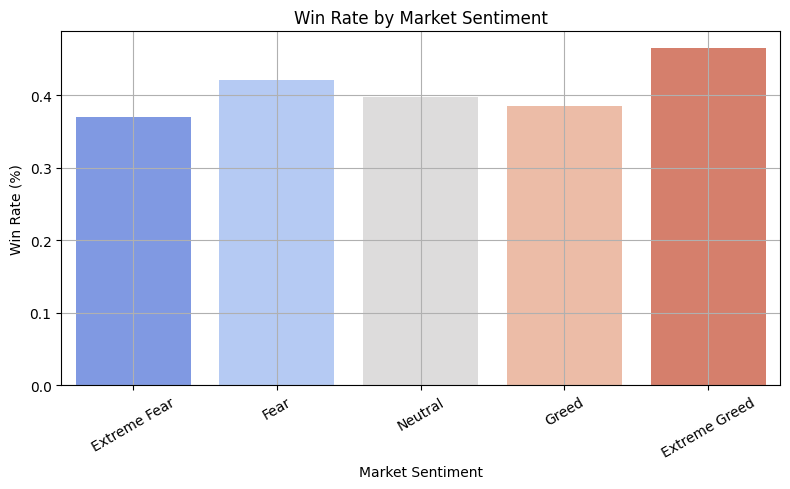

In [13]:

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.barplot(data=summary, x='classification', y='win_rate', palette='coolwarm')
plt.title('Win Rate by Market Sentiment')
plt.ylabel('Win Rate (%)')
plt.xlabel('Market Sentiment')
plt.xticks(rotation=30)
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\91770\AppData\Local\Temp\ipykernel_3296\30394567.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df, x='classification', y='Closed PnL', palette='coolwarm')


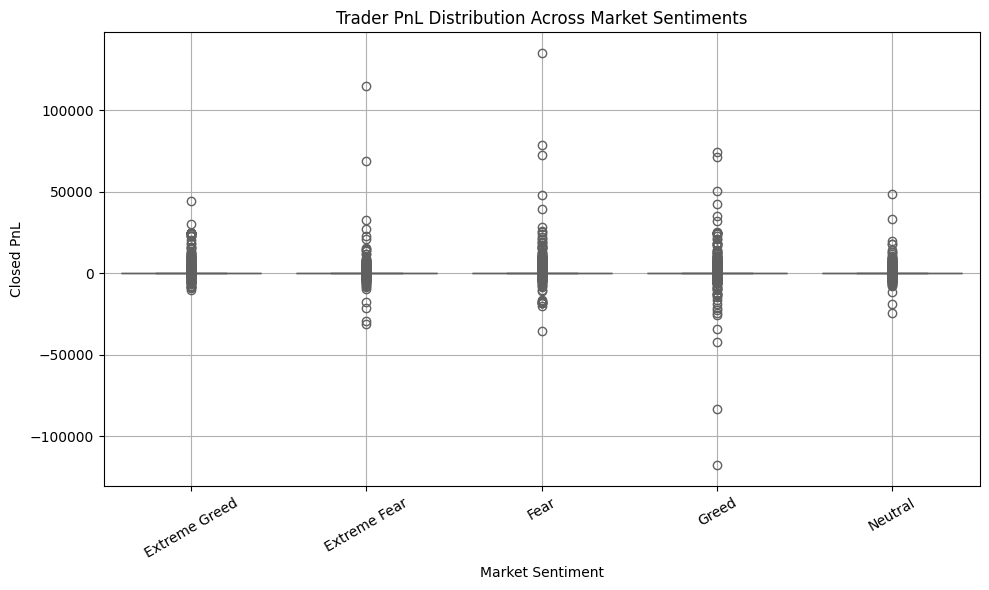

In [15]:
plt.figure(figsize=(10,6))
sns.boxplot(data=merged_df, x='classification', y='Closed PnL', palette='coolwarm')
plt.title('Trader PnL Distribution Across Market Sentiments')
plt.xlabel('Market Sentiment')
plt.ylabel('Closed PnL')
plt.xticks(rotation=30)
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\91770\AppData\Local\Temp\ipykernel_3296\1221371287.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary, x='classification', y='avg_trade_size_usd', palette='crest')


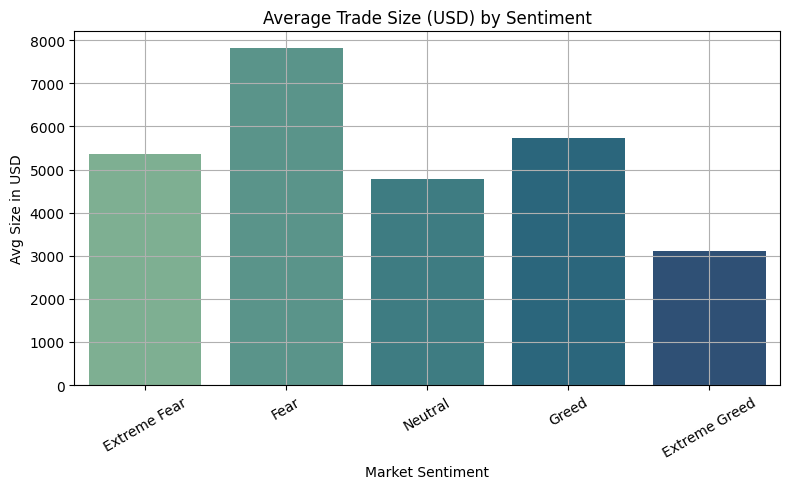

In [16]:
plt.figure(figsize=(8,5))
sns.barplot(data=summary, x='classification', y='avg_trade_size_usd', palette='crest')
plt.title('Average Trade Size (USD) by Sentiment')
plt.ylabel('Avg Size in USD')
plt.xlabel('Market Sentiment')
plt.xticks(rotation=30)
plt.grid(True)
plt.tight_layout()
plt.show()


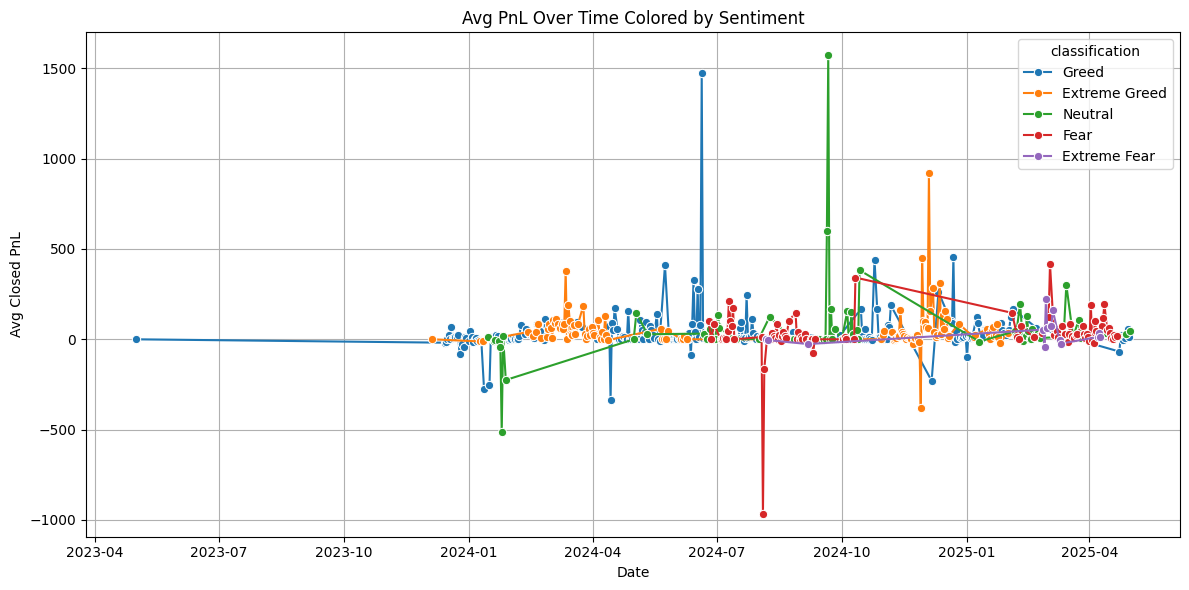

In [17]:
#  Daily avg PnL over time
daily_avg = merged_df.groupby(['trade_date', 'classification']).agg(
    avg_pnl=('Closed PnL', 'mean')
).reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=daily_avg, x='trade_date', y='avg_pnl', hue='classification', marker='o')
plt.title('Avg PnL Over Time Colored by Sentiment')
plt.xlabel('Date')
plt.ylabel('Avg Closed PnL')
plt.grid(True)
plt.tight_layout()
plt.show()
